In [2]:
# myDir = 'G:\Amin\Dropbox\mycourse 2017/'
myDir ='C:\\Users\\YYJ\\Desktop\\FIN580\\Homework1\\VolatilityForecasting\\src\\Data//'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
CD = pd.read_csv(myDir + 'CADUSD.csv', usecols= ['Date', 'Time', 'Close'])
CD['DateTime'] = pd.to_datetime(CD['Date'] + ' ' + CD['Time'])

In [4]:
CD.index= CD['DateTime']
CD.head()

,Date,Time,Close,DateTime
DateTime,,,,
2008-05-06 16:05:00,05/06/2008,16:05,0.9971,2008-05-06 16:05:00
2008-05-06 16:10:00,05/06/2008,16:10,0.9973,2008-05-06 16:10:00
2008-05-06 16:15:00,05/06/2008,16:15,0.9976,2008-05-06 16:15:00
2008-05-06 16:20:00,05/06/2008,16:20,0.9979,2008-05-06 16:20:00
2008-05-06 16:25:00,05/06/2008,16:25,0.9973,2008-05-06 16:25:00


In [5]:
del CD['Date'], CD['Time'], CD['DateTime']

In [7]:
CD.head()

,Close
DateTime,
2008-05-06 16:05:00,0.9971
2008-05-06 16:10:00,0.9973
2008-05-06 16:15:00,0.9976
2008-05-06 16:20:00,0.9979
2008-05-06 16:25:00,0.9973


In [6]:
CD2 = (CD[1:].values - CD[:-1].values)/CD[:-1].values

In [7]:
CDR = pd.DataFrame(CD2, index= CD.index[1:])
CDR.head()

,0
DateTime,
2008-05-06 16:10:00,0.000201
2008-05-06 16:15:00,0.000301
2008-05-06 16:20:00,0.000301
2008-05-06 16:25:00,-0.000601
2008-05-06 16:30:00,0.000100


In [8]:
def nanZeroCount(array):
    nanSum = np.isnan(array).sum()
    zeroSum = (array == 0).sum()
    return nanSum + zeroSum
CDR.resample('5T').asfreq().resample('1D').apply(nanZeroCount).head()

,0
DateTime,
2008-05-06,27.0
2008-05-07,37.0
2008-05-08,43.0
2008-05-09,121.0
2008-05-10,288.0


In [9]:
CDR.index = CDR.index + pd.to_timedelta('8H')

In [10]:
NanValues = CDR.resample('5T').asfreq().resample('1D').apply(nanZeroCount)

In [11]:
def nonZeroSTD(array):
    a = array[array != 0]
    return np.std(a)
CDR_STD = CDR.resample('5T').asfreq().resample('1D').apply(nonZeroSTD)

In [12]:
CDR_STD = CDR_STD[NanValues[0]<90]*np.sqrt(288*250)

In [13]:
CDR_STD.columns = ['nonZero STD']
CDR_STD.head()

,nonZero STD
DateTime,
2008-05-07,0.115757
2008-05-08,0.132862
2008-05-09,0.126128
2008-05-12,0.102447
2008-05-13,0.112723


In [14]:
CDR_STD.shape

(1275, 1)

In [15]:
MSE_Base = ((CDR_STD.values[0:-1] - CDR_STD.values[1:])**2).mean()
print MSE_Base

0.00068807643071


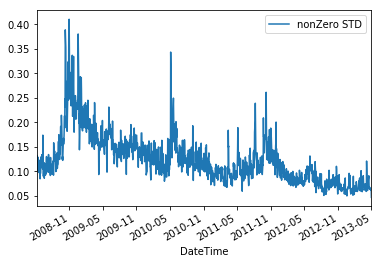

In [16]:
CDR_STD.plot()

In [17]:
LabelsTF = CDR_STD.values[0:-1] < CDR_STD.values[1:]
Labels = np.ones(LabelsTF.shape)
Labels[~LabelsTF] = -1
LabelsDF = pd.DataFrame(Labels, index = CDR_STD.index[:-1])
LabelsDF.loc[CDR_STD.index[-1]] = 1
LabelsDF.tail()

,0
DateTime,
2013-04-24,1.0
2013-04-25,-1.0
2013-04-29,1.0
2013-04-30,-1.0
2013-05-01,1.0


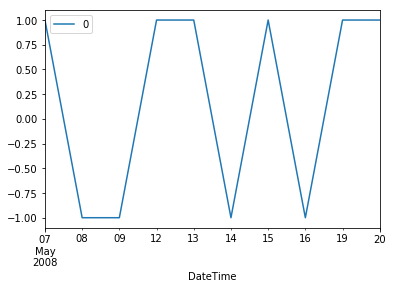

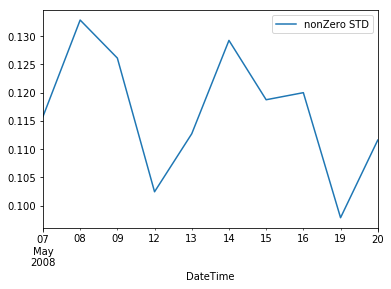

In [18]:
LabelsDF.head(10).plot()
CDR_STD.head(10).plot()

In [83]:
DailyData = CDR_STD.resample('1D').asfreq().fillna(method ='bfill')
LabelsDF = LabelsDF.resample('1D').asfreq().fillna(method ='bfill')
def ResampleDays(DatesTS, df = DailyData):
    DF1 = df.groupby(DatesTS.searchsorted(df.index)).nth(-1).dropna()
    try:
        DF1.index = DatesTS
    except:
        DF1 = DF1[:-1]
        DF1.index = DatesTS
    return DF1

In [84]:
SampleDays = pd.read_csv(myDir + 'v.csv', parse_dates =True, index_col = 0)
SampleDays = SampleDays.loc[CDR_STD.index][1:-1]
TrainingDates = SampleDays.index[(SampleDays.values ==1).flatten()]
TestDates = SampleDays.index[(SampleDays.values ==0).flatten()]


In [89]:
DailyData['nonZero STD'].values

array([ 0.11575707,  0.13286199,  0.12612805, ...,  0.06148829,
        0.06554698,  0.04716021])

In [91]:
DailyData.values

array([[ 0.11575707],
       [ 0.13286199],
       [ 0.12612805],
       ..., 
       [ 0.06148829],
       [ 0.06554698],
       [ 0.04716021]])

0.000742403590731
max % improvement over base MSE:  58.8625623013


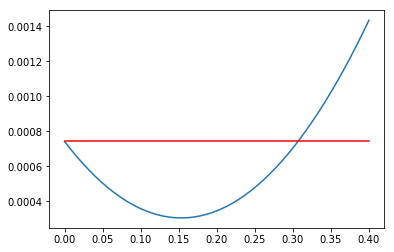

In [106]:
def plotMSEClass(dateRange, deltaRange, yh_t_df):
    size = len(dateRange)
    DS = ResampleDays(dateRange, DailyData['nonZero STD']).values.reshape(1, size)
    DSP1D = ResampleDays(dateRange + pd.Timedelta('1 day'), DailyData['nonZero STD']).values.reshape(1, size)
    yh_t = ResampleDays(dateRange, yh_t_df).values.reshape(1, size)
    SEV = []
    for delta in deltaRange:
        SE_SVM1 = ((DSP1D - (1+yh_t*delta)* DS)**2).mean()
        SEV.append(SE_SVM1)

    plt.plot(deltaRange, SEV)
    MSE_Base = ((DSP1D - DS)**2).mean()
    print MSE_Base
    plt.plot(deltaRange, [MSE_Base]*50, 'r')
    print 'max % improvement over base MSE: ', (-np.min(SEV)+ MSE_Base)/MSE_Base*100

deltaRange = np.linspace(0, .4, 50)
yh_t = LabelsDF # clf.predict(CDR_STD.values[0:-1])
plotMSEClass(TrainingDates, deltaRange, yh_t)

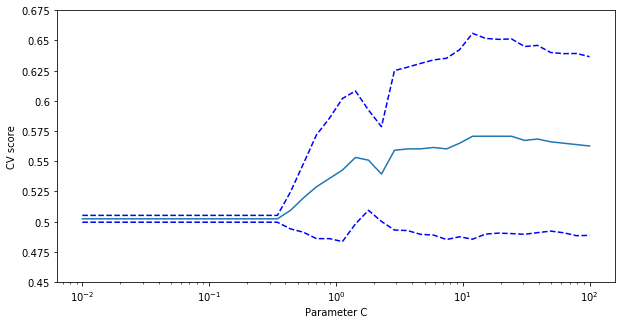

In [94]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
svc = svm.SVC(kernel='linear')
C_s = np.logspace(-2, 2, 40)

TrainingSet = ResampleDays(TrainingDates, df = DailyData)
TrainingLabels = ResampleDays(TrainingDates, df = LabelsDF)

X = TrainingSet.values
y = TrainingLabels.values.flatten()

scores0 = list()
scores_std0 = list()
for C in C_s:
    svc.C = C
    this_scores = cross_val_score(svc, X, y, cv = 10)
    scores0.append(np.mean(this_scores))
    scores_std0.append(np.std(this_scores))

# Do the plotting
import matplotlib.pyplot as plt
plt.figure(1, figsize=(10, 5))
plt.clf()
plt.semilogx(C_s, scores0)
plt.semilogx(C_s, np.array(scores0) + np.array(scores_std0), 'b--')
plt.semilogx(C_s, np.array(scores0) - np.array(scores_std0), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
#plt.ylim(0, 1.1)
plt.show()

In [95]:
svc.C = 2
svc.fit(TrainingSet.values , TrainingLabels.values.flatten())

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

max % improvement over base MSE:  4.35604852397


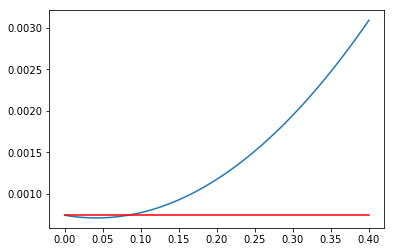

In [96]:
deltaRange = np.linspace(0, .4, 50)
yh_t0 = pd.DataFrame(svc.predict(TrainingSet.values), index = TrainingDates)
plotMSEClass(TrainingDates, deltaRange, yh_t0)

In [97]:
DailyData['diff'] = DailyData.diff()
DailyData.head(10)

,nonZero STD,diff
DateTime,,
2008-05-07,0.115757,NaN
2008-05-08,0.132862,0.017105
2008-05-09,0.126128,-0.006734
2008-05-10,0.102447,-0.023681
2008-05-11,0.102447,0.000000
2008-05-12,0.102447,0.000000
2008-05-13,0.112723,0.010276
2008-05-14,0.129255,0.016532
2008-05-15,0.118747,-0.010509


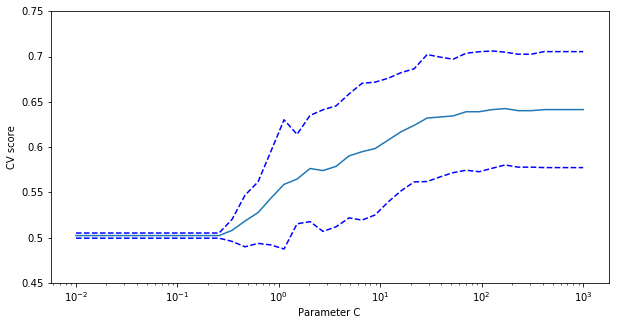

In [98]:
svc = svm.SVC(kernel='linear')
C_s = np.logspace(-2, 3, 40)

TrainingSet = ResampleDays(TrainingDates, df = DailyData)
TrainingLabels = ResampleDays(TrainingDates, df = LabelsDF)

X = TrainingSet.values
y = TrainingLabels.values.flatten()

scores1 = list()
scores_std1 = list()
for C in C_s:
    svc.C = C
    this_scores = cross_val_score(svc, X, y, cv = 10)
    scores1.append(np.mean(this_scores))
    scores_std1.append(np.std(this_scores))

# Do the plotting
import matplotlib.pyplot as plt
plt.figure(1, figsize=(10, 5))
plt.clf()
plt.semilogx(C_s, scores1)
plt.semilogx(C_s, np.array(scores1) + np.array(scores_std1), 'b--')
plt.semilogx(C_s, np.array(scores1) - np.array(scores_std1), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
#plt.ylim(0, 1.1)
plt.show()


In [99]:
svc.C = 10**1.3
svc.fit(TrainingSet.values , TrainingLabels.values.flatten())

deltaRange = np.linspace(0, .4, 50)
yh_t1 = pd.DataFrame(svc.predict(TrainingSet.values), index = TrainingDates)
plotMSEClass(TrainingDates, deltaRange, yh_t1)

SVC(C=19.9526231497, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [82]:
print np.abs(TrainingLabels.values - yh_t1.values).sum(), np.abs(TrainingLabels.values - yh_t0.values).sum()

632.0 766.0


In [101]:
def nonZeroMean(array):
    a = array[array != 0]
    return np.mean(a)
CDR_MEAN = CDR.resample('5T').asfreq().resample('1D').apply(nonZeroMean)
DailyData['Return'] = CDR_MEAN * 250 * 288 
DailyData['Return'].fillna(method = 'ffill', inplace = True)

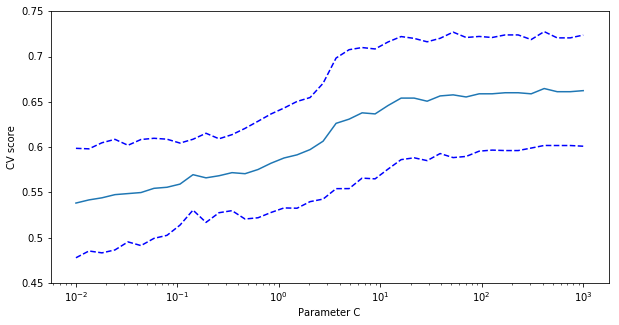

In [102]:
svc = svm.SVC(kernel='linear')
C_s = np.logspace(-2, 3, 40)

TrainingSet = ResampleDays(TrainingDates, df = DailyData)
TrainingLabels = ResampleDays(TrainingDates, df = LabelsDF)

X = TrainingSet.values
y = TrainingLabels.values.flatten()

scores2 = list()
scores_std2 = list()
for C in C_s:
    svc.C = C
    this_scores = cross_val_score(svc, X, y, cv = 10)
    scores2.append(np.mean(this_scores))
    scores_std2.append(np.std(this_scores))

# Do the plotting
import matplotlib.pyplot as plt
plt.figure(1, figsize=(10, 5))
plt.clf()
plt.semilogx(C_s, scores2)
plt.semilogx(C_s, np.array(scores2) + np.array(scores_std2), 'b--')
plt.semilogx(C_s, np.array(scores2) - np.array(scores_std2), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
#plt.ylim(0, 1.1)
plt.show()

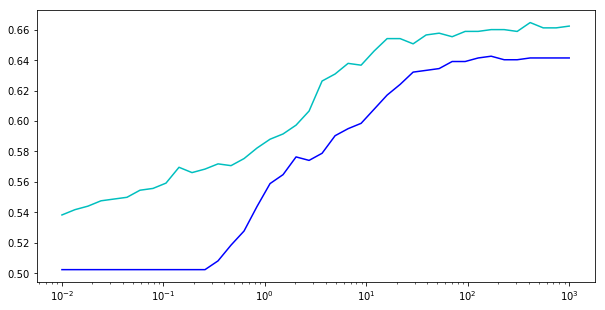

In [103]:
plt.figure(1, figsize=(10, 5))
plt.clf()
plt.semilogx(C_s, scores1, 'b')
plt.semilogx(C_s, scores2, 'c')

0.000742403590731
max % improvement over base MSE:  15.0689477236


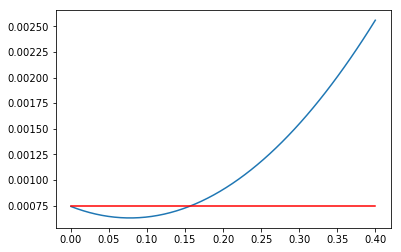

In [115]:
svc.C = 10**1
svc.fit(TrainingSet.values , TrainingLabels.values.flatten())
TestLabels = ResampleDays(TestDates, df = LabelsDF)

deltaRange = np.linspace(0, .4, 50)
yh_t1 = pd.DataFrame(svc.predict(TrainingSet.values), index = TrainingDates)
plotMSEClass(TrainingDates, deltaRange, yh_t1)

In [104]:
DailyData['Return5D'] = DailyData['Return'].rolling(window=5).sum().fillna(0)
DailyData.head()

,nonZero STD,diff,Return,Return5D
DateTime,,,,
2008-05-07,0.115757,NaN,-1.386308,0.00000
2008-05-08,0.132862,0.017105,-2.907592,0.00000
2008-05-09,0.126128,-0.006734,3.438723,0.00000
2008-05-10,0.102447,-0.023681,7.244918,0.00000
2008-05-11,0.102447,0.000000,7.244918,13.63466


In [ ]:
svc = svm.SVC(kernel='linear')
C_s = np.logspace(-2, 3, 40)

TrainingSet = ResampleDays(TrainingDates, df = DailyData)
TrainingLabels = ResampleDays(TrainingDates, df = LabelsDF)

X = TrainingSet[['nonZero STD', 'Return5D', 'diff']].values
y = TrainingLabels.values.flatten()

scores3 = list()
scores_std3 = list()
for C in C_s:
    svc.C = C
    this_scores = cross_val_score(svc, X, y, cv = 10)
    scores3.append(np.mean(this_scores))
    scores_std3.append(np.std(this_scores))

# Do the plotting
import matplotlib.pyplot as plt
plt.figure(1, figsize=(10, 5))
plt.clf()
plt.semilogx(C_s, scores3)
plt.semilogx(C_s, np.array(scores3) + np.array(scores_std3), 'b--')
plt.semilogx(C_s, np.array(scores3) - np.array(scores_std3), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
#plt.ylim(0, 1.1)
plt.show()